In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, Dataset

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, v2
from torchmetrics.classification import MultilabelAccuracy
from torchmetrics import ConfusionMatrix, Accuracy, Precision, Recall, MeanMetric

%config InlineBackend.figure_format='retina'

In [2]:
device = torch.device("mps")

In [3]:
class MultiLabelDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file  (str): Path to the CSV file with annotations.
            img_dir   (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                                            on an image sample.
        """
        self.dataframe = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        # If you like, you can store the columns referencing labels:
        # (Assuming the first column is 'filename', and the rest are labels)
        self.label_columns = self.dataframe.columns[1:]  # piano -> other

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # 1) Get row from dataframe
        row = self.dataframe.iloc[idx]

        # 2) Construct image path
        img_path = os.path.join(self.img_dir, row['filename'])

        # 3) Open and transform image
        image = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)

        # 4) Build multi-hot label vector
        #    Extract columns piano, guitar, bass, brass, strings, other
        label_values = row[self.label_columns].values.astype('float32')
        # label_values is shape (6,) -> e.g. [1,0,1,0,1,0]

        # Convert to a PyTorch tensor
        labels = torch.tensor(label_values, dtype=torch.float32)

        return image, labels

In [4]:
class AddPixelwiseNoise(object):
    def __init__(self, std=0.02, clamp=True):
        self.std = std
        self.clamp = clamp

    def __call__(self, img_tensor):
        # img_tensor in [0,1], shape [channels, height, width]
        noise = torch.randn_like(img_tensor) * self.std
        noised_img = img_tensor + noise
        if self.clamp:
            noised_img = torch.clamp(noised_img, 0.0, 1.0)
        return noised_img
    
# Define transforms
transform = transforms.Compose([
    # 1) Crop out edges (CenterCrop or RandomCrop), e.g. 800x800 from 1000x2000
    transforms.RandomCrop((2000, 700)),
    
    transforms.Resize((400, 140)),
    
    transforms.ToTensor(),
    AddPixelwiseNoise(std=0.02),
])

# Load entire dataset
# full_dataset = datasets.ImageFolder(root='dataset_root', transform=transform)
full_dataset = MultiLabelDataset(
    csv_file='data/labels.csv',
    img_dir='data/spectrograms',
    transform=transform
)

# Define split ratios (e.g., 70% train, 15% val, 15% test)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Compute lengths
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Perform random split
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size],
                                                        generator=torch.Generator().manual_seed(42))  # fixed seed for reproducibility

# DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Class mapping
class_names = ["piano", "bass", "drums", "guitar", "synth"]
num_classes = len(class_names)

In [5]:
# Define model
model = torchvision.models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, num_classes)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
model = model.to(device)

optimiser = torch.optim.AdamW(params=model.parameters(), lr=1e-3)
criteria = nn.BCEWithLogitsLoss()

train_loss = MeanMetric().to(device)
epochs = 10

In [7]:
# a function for training one epoch
def train_one_epoch():
   # Prepare for storing loss and accuracy
   losses = MeanMetric().to(device)
   acc = MultilabelAccuracy(num_labels=num_classes, threshold=0.5).to(device)
   model.train()
   for X, Y in train_dataloader:
      X = X.to(device) 
      Y = Y.to(device)
      optimiser.zero_grad()
      logits = model(X)
      loss = criteria(logits, Y)
      loss.backward()
      optimiser.step() 
      losses.update(loss, X.size(0))
      probs = torch.sigmoid(logits)
      acc.update(probs, Y)
   return losses.compute() .item(), acc.compute().item()

In [8]:
# a function for validation one epoch
def validation_one_epoch():
   losses = MeanMetric().to(device)
   acc = MultilabelAccuracy(num_labels=num_classes, threshold=0.5).to(device)
   model.eval()

   for X, Y in val_dataloader:
      X = X.to(device) 
      Y = Y.to(device) 
      logits = model(X)
      loss = criteria(logits, Y)
      losses.update(loss, X.size(0)) 
      probs = torch.sigmoid(logits)
      acc.update(probs, Y)

   return losses.compute().item(), acc.compute().item()

In [9]:
for i in range(epochs):
   train_loss, train_acc = train_one_epoch() # training
   val_loss, val_acc = validation_one_epoch() # validation
   print("Epoch:", i, "| Train Loss:", round(train_loss, 3), "| Train Accuracy", round(train_acc, 3),
            "| Validation Loss", round(val_loss, 3), "| Validation Accuracy", round(val_acc, 3))

Epoch: 0 | Train Loss: 0.458 | Train Accuracy 0.769 | Validation Loss 0.909 | Validation Accuracy 0.689
Epoch: 1 | Train Loss: 0.356 | Train Accuracy 0.836 | Validation Loss 0.59 | Validation Accuracy 0.775
Epoch: 2 | Train Loss: 0.313 | Train Accuracy 0.862 | Validation Loss 1.044 | Validation Accuracy 0.731
Epoch: 3 | Train Loss: 0.272 | Train Accuracy 0.882 | Validation Loss 0.364 | Validation Accuracy 0.825
Epoch: 4 | Train Loss: 0.242 | Train Accuracy 0.899 | Validation Loss 0.59 | Validation Accuracy 0.796
Epoch: 5 | Train Loss: 0.224 | Train Accuracy 0.908 | Validation Loss 0.311 | Validation Accuracy 0.866
Epoch: 6 | Train Loss: 0.194 | Train Accuracy 0.922 | Validation Loss 0.468 | Validation Accuracy 0.825
Epoch: 7 | Train Loss: 0.203 | Train Accuracy 0.917 | Validation Loss 0.541 | Validation Accuracy 0.815
Epoch: 8 | Train Loss: 0.173 | Train Accuracy 0.933 | Validation Loss 0.373 | Validation Accuracy 0.861
Epoch: 9 | Train Loss: 0.153 | Train Accuracy 0.94 | Validation Lo

In [10]:
from torchmetrics.classification import MultilabelConfusionMatrix, MultilabelAccuracy

# Create multi-label confusion matrix & accuracy objects
test_confusion_matrix = MultilabelConfusionMatrix(num_labels=num_classes)
test_acc = MultilabelAccuracy(num_labels=num_classes, threshold=0.5)

model = model.to('cpu')
model.eval()

with torch.no_grad():
    for X, Y in test_dataloader:
        # Forward pass => raw logits, shape [N, C]
        logits = model(X)
        
        # Convert logits to probabilities (float) with sigmoid
        probs = torch.sigmoid(logits)  # shape [N, C] in [0, 1]
        
        # Binarize at threshold=0.5 => shape [N, C] of 0/1 (int)
        preds = (probs >= 0.5).int()

        # Update confusion matrix & accuracy
        test_confusion_matrix.update(preds, Y.int())
        test_acc.update(preds, Y)

# Compute the final metrics over the entire dataset
cm = test_confusion_matrix.compute()  
acc = test_acc.compute()

print("Multi-Label Confusion Matrix (per-label):\n", cm)
print("Multi-Label Accuracy:", acc.item())

Multi-Label Confusion Matrix (per-label):
 tensor([[[153,  34],
         [ 11, 173]],

        [[182,  10],
         [ 14, 165]],

        [[193,   5],
         [  3, 170]],

        [[128,  48],
         [ 27, 168]],

        [[183,   5],
         [ 59, 124]]])
Multi-Label Accuracy: 0.8835578560829163


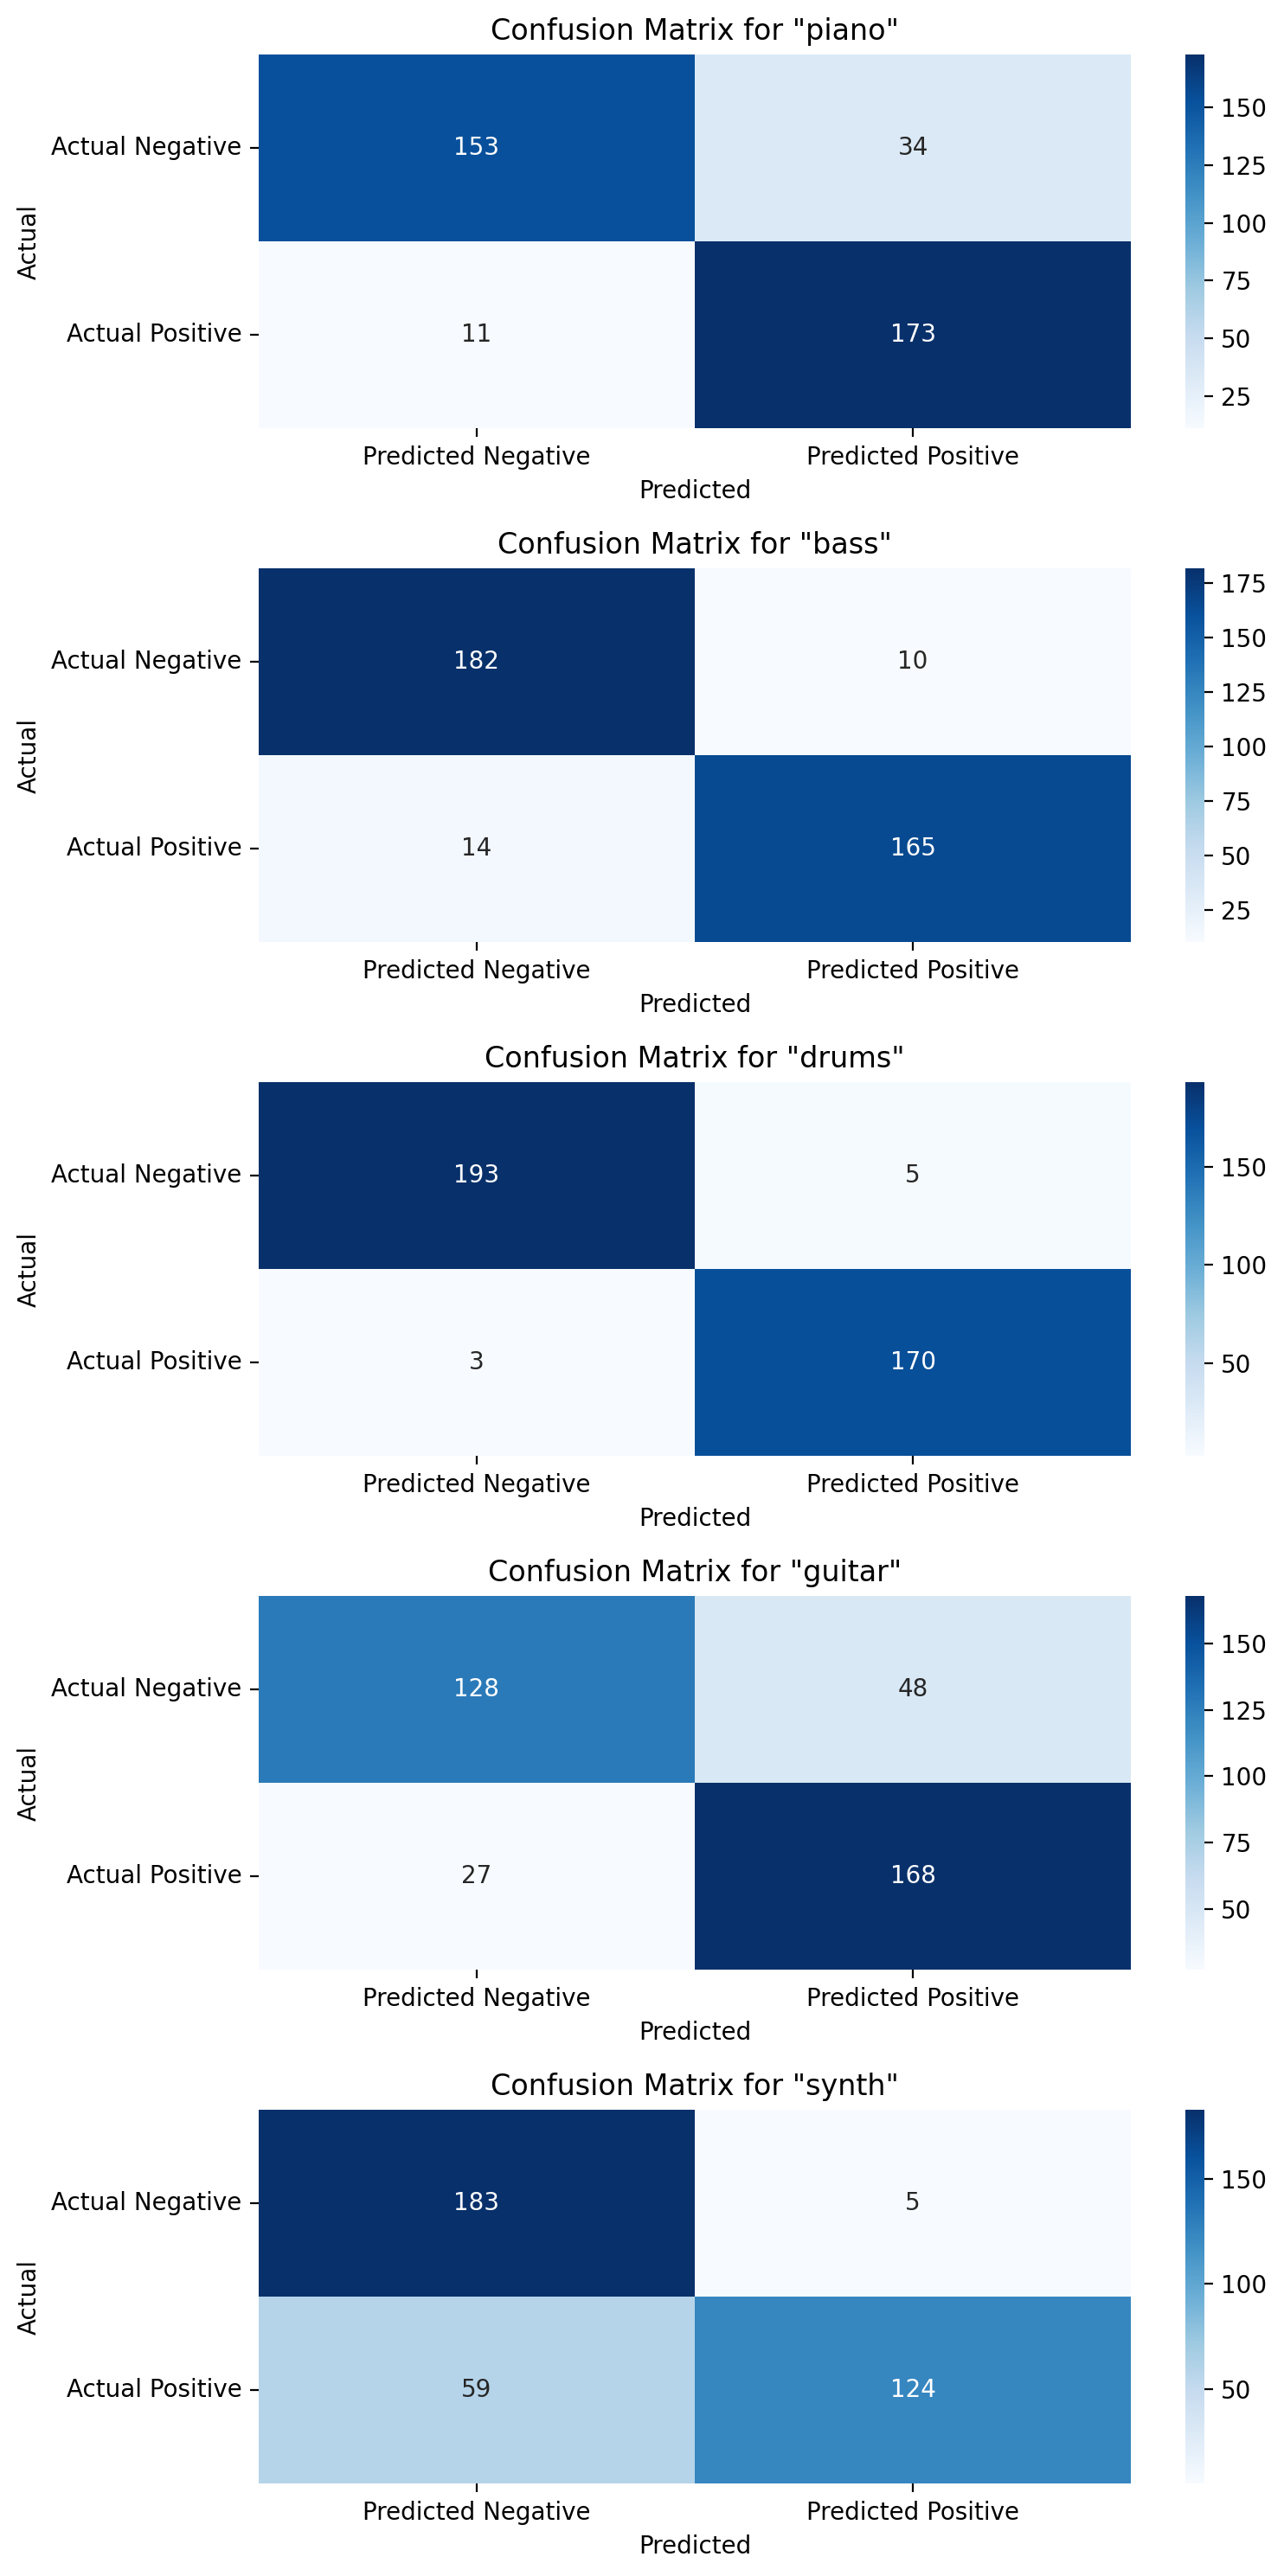

In [11]:
# Plot confusion matrix heatmaps for each instrument
fig, axes = plt.subplots(5, 1, figsize=(8, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.heatmap(
        cm[i].numpy(),
        annot=True,
        fmt='g',
        cmap='Blues',
        xticklabels=['Predicted Negative', 'Predicted Positive'],
        yticklabels=['Actual Negative', 'Actual Positive'],
        ax=ax
    )
    ax.set_title(f'Confusion Matrix for "{class_names[i]}"')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [12]:
test_confusion_matrix=ConfusionMatrix(task="multiclass", num_classes=num_classes)
test_acc = Accuracy(task='multiclass', num_classes=num_classes)
model = model.to('cpu') # Move the model back to CPU
model.eval() # Set model to evaluation mode 

with torch.no_grad():
   for X, Y in test_dataloader:
      preds = model(X) # Model forward
      preds = preds.argmax(dim=1) # Obtain the final predicted class
      # Store accuracy per batch
      test_confusion_matrix.update(preds, Y)
      test_acc.update(preds, Y)
   # Print the results
   print ("Confusion Matrix: \n", test_confusion_matrix.compute())
   print ("Accuracy:", test_acc.compute().item())

ValueError: Either `preds` and `target` both should have the (same) shape (N, ...), or `target` should be (N, ...) and `preds` should be (N, C, ...).

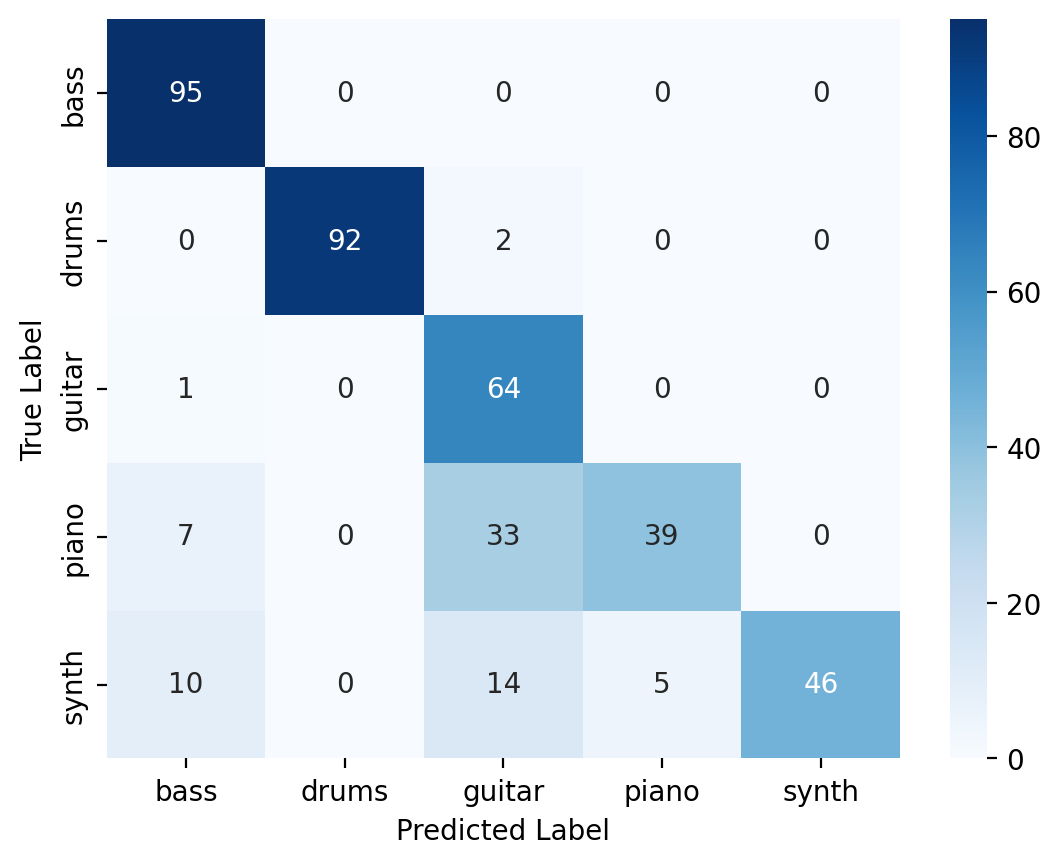

In [ ]:
# Create a heatmap for better confusion matrix visualization
sns.heatmap(test_confusion_matrix.compute(), annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt. show()